In [2]:
! pip install statsmodels
! pip install pandas
! pip install numpy
! pip install sklearn
! pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 24.8 MB/s eta 0:00:00 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variabl

In [3]:
import requests

url = "http://api.weatherapi.com/v1/current.json"
params = {
    'key': 'f446c70ff0e146d9b6b160659241910',  # Replace with your API key
    'q': '19.0760,72.8777'  
}
response = requests.get(url, params=params)
data = response.json()

# Get cloud cover
cloud_cover = data['current']['cloud']
print(f"Cloud cover: {cloud_cover}%")


Cloud cover: 25%


In [4]:
import requests
import datetime
import json

# Function to get historical weather data from WeatherAPI
def get_historical_weather(api_key, location, date):
    url = f"http://api.weatherapi.com/v1/history.json"
    
    params = {
        'key': api_key,
        'q': location,  # Location can be a city name or latitude/longitude
        'dt': date,     # Date in YYYY-MM-DD format
    }
    
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None

# Function to retrieve weather data for the past year, including temperature, humidity, wind, precipitation, and cloud cover
def get_weather_past_year(api_key, location):
    weather_data_list = []
    
    for i in range(365):
        date = (datetime.datetime.now() - datetime.timedelta(days=i)).strftime('%Y-%m-%d')
        weather_data = get_historical_weather(api_key, location, date)
        
        if weather_data:
            forecast_day = weather_data.get('forecast', {}).get('forecastday', [])[0].get('day', {})
            temp_max = forecast_day.get('maxtemp_c', None)  # Max temperature in Celsius
            temp_min = forecast_day.get('mintemp_c', None)  # Min temperature in Celsius
            avg_temp = forecast_day.get('avgtemp_c', None)  # Average temperature in Celsius
            humidity = forecast_day.get('avghumidity', None)  # Average humidity in %
            wind_speed = forecast_day.get('maxwind_kph', None)  # Max wind speed in kph
            precipitation = forecast_day.get('totalprecip_mm', 0)  # Total precipitation in mm
            #cloud_cover = forecast_day.get('cloud', None)  # Cloud cover in percentage
            
            # Save the data in a structured format
            weather_data_list.append({
                'date': date,
                'max_temp_c': temp_max,
                'min_temp_c': temp_min,
                'avg_temp_c': avg_temp,
                'humidity': humidity,
                'wind_speed_kph': wind_speed,
                'precipitation_mm': precipitation,
                #'cloud_cover': cloud_cover,  # Cloud cover
            })
            
            # print(f"Date: {date} | Max Temp: {temp_max}°C | Min Temp: {temp_min}°C | "
            #       f"Avg Temp: {avg_temp}°C | Humidity: {humidity}% | Wind Speed: {wind_speed} kph | "
            #       f"Precipitation: {precipitation} mm | Cloud Cover: {cloud_cover}%")
    
    return weather_data_list

# Your WeatherAPI API Key
api_key = 'f446c70ff0e146d9b6b160659241910'

# Location for Mumbai
location = 'Mumbai, India'  # Specify Mumbai

# Get weather data for the past year
weather_data = get_weather_past_year(api_key, location)

# Optionally, save the data to a JSON file
with open('mumbai_weather_data_past_year.json', 'w') as f:
    json.dump(weather_data, f, indent=4)


In [5]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load weather data from JSON into a DataFrame
weather_df = pd.read_json('mumbai_weather_data_past_year.json')

# Drop rows with missing values, or alternatively use interpolation
weather_df = weather_df.dropna()

# Convert the 'date' column to datetime format
weather_df['date'] = pd.to_datetime(weather_df['date'])

# Set the 'date' column as the index for time series operations
weather_df.set_index('date', inplace=True)

weather_df['day_of_week'] = weather_df.index.dayofweek
weather_df['month'] = weather_df.index.month
weather_df['season'] = (weather_df.index.month % 12 + 3) // 3 

# Check the result
print(weather_df.head())


            max_temp_c  min_temp_c  avg_temp_c  humidity  wind_speed_kph  \
date                                                                       
2024-10-20        29.6        27.3        28.4        77            12.2   
2024-10-19        29.6        27.6        28.4        79            15.5   
2024-10-18        30.6        28.3        29.3        76             9.0   
2024-10-17        30.3        27.9        28.9        77             9.0   
2024-10-16        31.4        27.5        29.2        76            11.5   

            precipitation_mm  day_of_week  month  season  
date                                                      
2024-10-20              1.84            6     10       4  
2024-10-19              8.04            5     10       4  
2024-10-18              1.80            4     10       4  
2024-10-17              2.70            3     10       4  
2024-10-16              3.51            2     10       4  


In [6]:
# last_actual_value = weather_df['precipitation_mm'].iloc[-len(y_test)-1]
# if last_actual_value < 0:
#     last_actual_value = 0  # Or some other handling logic

NameError: name 'y_test' is not defined

In [7]:
from statsmodels.tsa.stattools import adfuller, kpss

# Apply ADFuller Test
result_adf = adfuller(weather_df['precipitation_mm'])
print('ADF Test Statistic:', result_adf[0])
print('p-value:', result_adf[1])

# Apply KPSS Test
from statsmodels.tsa.stattools import kpss

def kpss_test(series):
    result = kpss(series, regression='c', nlags='auto')
    print('KPSS Test Statistic:', result[0])
    print('p-value:', result[1])

kpss_test(weather_df['precipitation_mm'])


ADF Test Statistic: -6.699467873500022
p-value: 3.922609752784132e-09
KPSS Test Statistic: 1.2991925521007064
p-value: 0.01


/tmp/ipykernel_6921/1046544964.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags='auto')


In [8]:
weather_df['precipitation_diff'] = weather_df['precipitation_mm'].diff().dropna()
result_adf = adfuller(weather_df['precipitation_diff'].dropna())
print('ADF Test Statistic (after differencing):', result_adf[0])
print('p-value:', result_adf[1])

kpss_test(weather_df['precipitation_diff'].dropna())


ADF Test Statistic (after differencing): -8.247519713057185
p-value: 5.502788016053186e-13
KPSS Test Statistic: 0.05777924467587771
p-value: 0.1


/tmp/ipykernel_6921/1046544964.py:12: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c', nlags='auto')


In [9]:
print(weather_df['precipitation_diff'].value_counts())
print(weather_df['precipitation_diff'].describe())

precipitation_diff
 0.00    181
-0.02      3
-0.01      3
-0.17      2
-0.34      2
        ... 
 0.30      1
 3.86      1
 0.91      1
-3.89      1
-5.21      1
Name: count, Length: 175, dtype: int64
count    364.000000
mean      -0.005055
std       17.240493
min     -148.930000
25%       -0.010000
50%        0.000000
75%        0.002500
max      209.000000
Name: precipitation_diff, dtype: float64


<Figure size 1000x600 with 0 Axes>

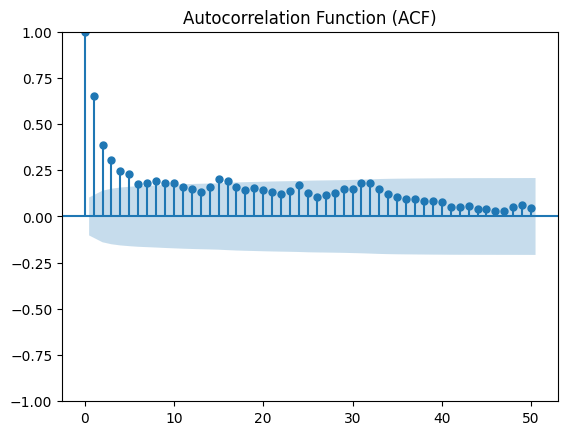

<Figure size 1000x600 with 0 Axes>

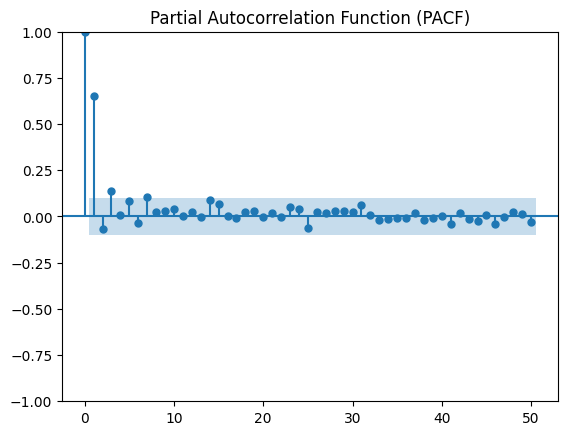

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF
plt.figure(figsize=(10,6))
plot_acf(weather_df['precipitation_mm'], lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plt.figure(figsize=(10,6))
plot_pacf(weather_df['precipitation_mm'], lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


<Figure size 1200x800 with 0 Axes>

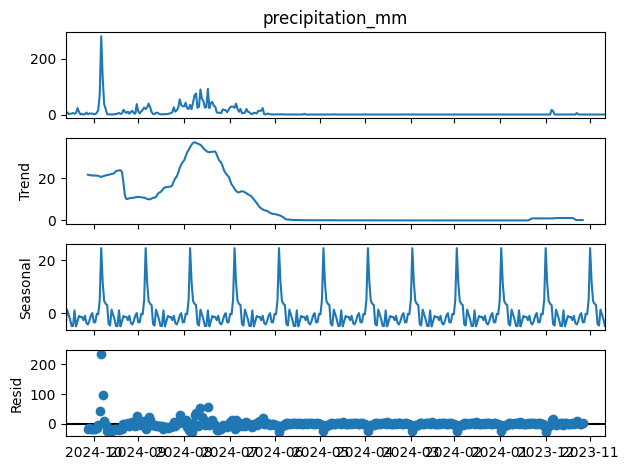

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(weather_df['precipitation_mm'], model='additive', period=30)

# Plot the decomposition
plt.figure(figsize=(12,8))

decomposition.plot()
plt.show()


2024-10-20 04:22:09.895552: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-20 04:22:09.992563: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-20 04:22:10.083141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-20 04:22:10.186151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-20 04:22:10.237043: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-20 04:22:10.589524: I tensorflow/core/platform/cpu_feature_gu

Epoch 1/50


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 295.2437 - val_loss: 6.9251
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 379.2031 - val_loss: 6.9170
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 285.3358 - val_loss: 6.9198
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 619.9557 - val_loss: 6.9227
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 392.1118 - val_loss: 6.9208
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 455.3739 - val_loss: 6.9269
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 313.0076 - val_loss: 6.9649
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 305.1600 - val_loss: 7.0081
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 291.9293 - val_loss: 7.0690
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 346.9103 - val_loss: 7.2570
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 218.8378 - val_loss: 7.3012
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 224.9093 - val_loss: 7.460

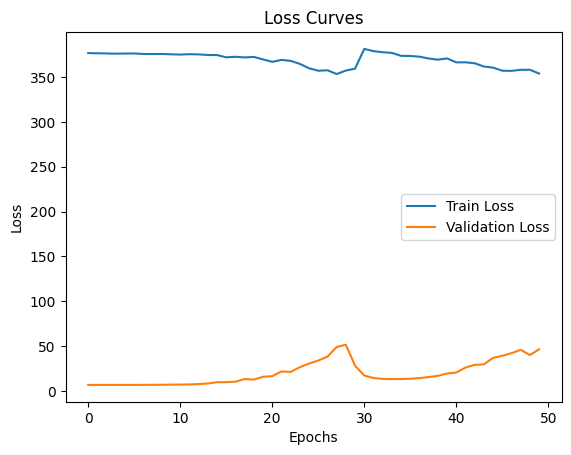

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


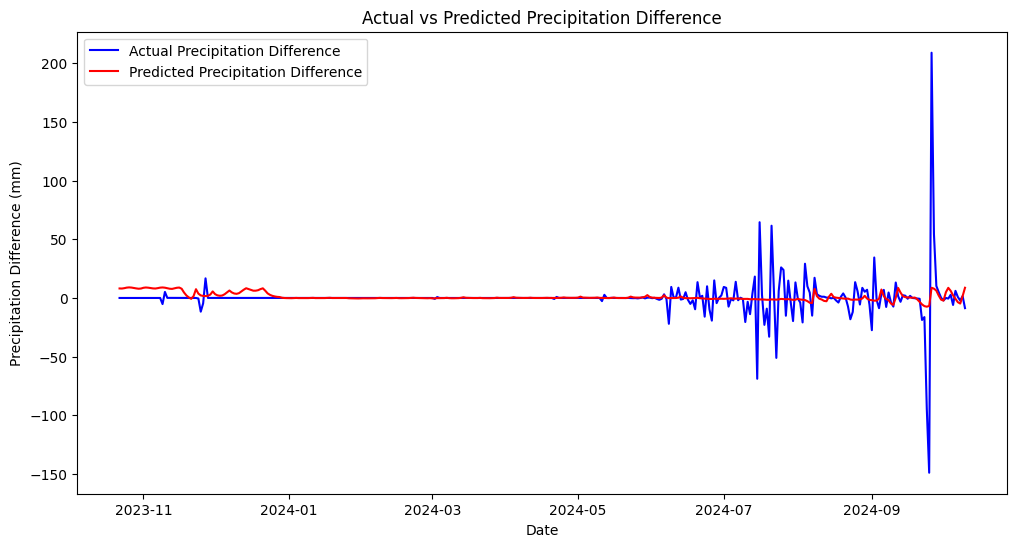

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


# Feature Engineering: Extracting Time Features
# weather_df['day_of_week'] = weather_df.index.dayofweek
# weather_df['month'] = weather_df.index.month
# weather_df['season'] = (weather_df.index.month % 12 + 3) // 3  # 1: Spring, 2: Summer, 3: Fall, 4: Winter

# Create the target variable 'precipitation_diff'
#weather_df['precipitation_diff'] = weather_df['precipitation_mm'].diff()
#weather_df.dropna(inplace=True)  # Drop NaN values resulting from the diff

# Select features for the model
features = ['avg_temp_c', 'humidity', 'wind_speed_kph', 'day_of_week', 'month', 'season']
X = weather_df[features].values
y = weather_df['precipitation_diff'].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Function to create sequences for LSTM
def create_sequences(data, labels, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(labels[i + sequence_length])  # Target is the value after the sequence
    return np.array(sequences), np.array(targets)

# Create sequences
sequence_length = 10  # You can adjust this value
X_sequences, y_sequences = create_sequences(X_scaled, y, sequence_length)

# Reshape input for LSTM (samples, time_steps, features)
X_sequences = X_sequences.reshape(X_sequences.shape[0], X_sequences.shape[1], X_sequences.shape[2])

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_sequences.shape[1], X_sequences.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for predicting precipitation difference

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_sequences, y_sequences, epochs=50, batch_size=32, validation_split=0.2)

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make predictions
predicted_diff = model.predict(X_sequences)

# Visualize predictions against actual values
plt.figure(figsize=(12, 6))
plt.plot(weather_df.index[sequence_length:], y[sequence_length:], label='Actual Precipitation Difference', color='blue')
plt.plot(weather_df.index[sequence_length:], predicted_diff, label='Predicted Precipitation Difference', color='red')
plt.title('Actual vs Predicted Precipitation Difference')
plt.xlabel('Date')
plt.ylabel('Precipitation Difference (mm)')
plt.legend()
plt.show()

In [13]:
import joblib

# Save the trained model to a .pkl file
model_filename = 'lstm_weather_model.pkl'
joblib.dump(model, model_filename)

['lstm_weather_model.pkl']